<a href="https://colab.research.google.com/github/Husayn01/ML_Projects/blob/main/Rain_in_Australia_Decision_Tree_and_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from kagglehub import load_dataset, KaggleDatasetAdapter

In [3]:
# Load the dataset
df = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "jsphyg/weather-dataset-rattle-package",
    "weatherAUS.csv",
)
print("First 5 records:")
print(df.head())

<ipython-input-3-fb263192d69d>:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = load_dataset(


100%|██████████| 3.83M/3.83M [00:00<00:00, 34.0MB/s]

Extracting zip of weatherAUS.csv...


First 5 records:
         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0

In [4]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am      

In [5]:
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


In [6]:
# Remove rows where target variable is missing
df.dropna(subset=['RainTomorrow'], inplace=True)
print(f"\nDataset shape after removing missing targets: {df.shape}")


Dataset shape after removing missing targets: (142193, 23)


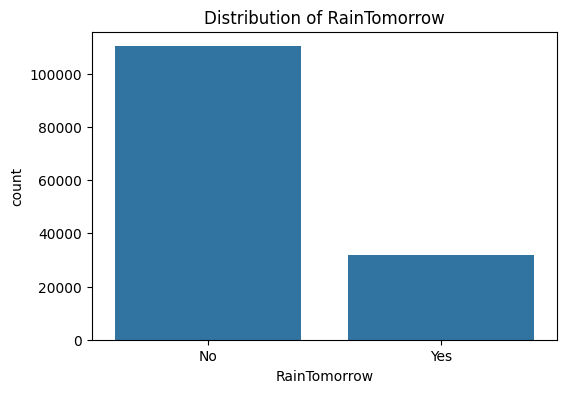

In [7]:
# Visualize target distribution
plt.figure(figsize=(6, 4))
plt.title('Distribution of RainTomorrow')
sns.countplot(data=df, x='RainTomorrow')
plt.show()

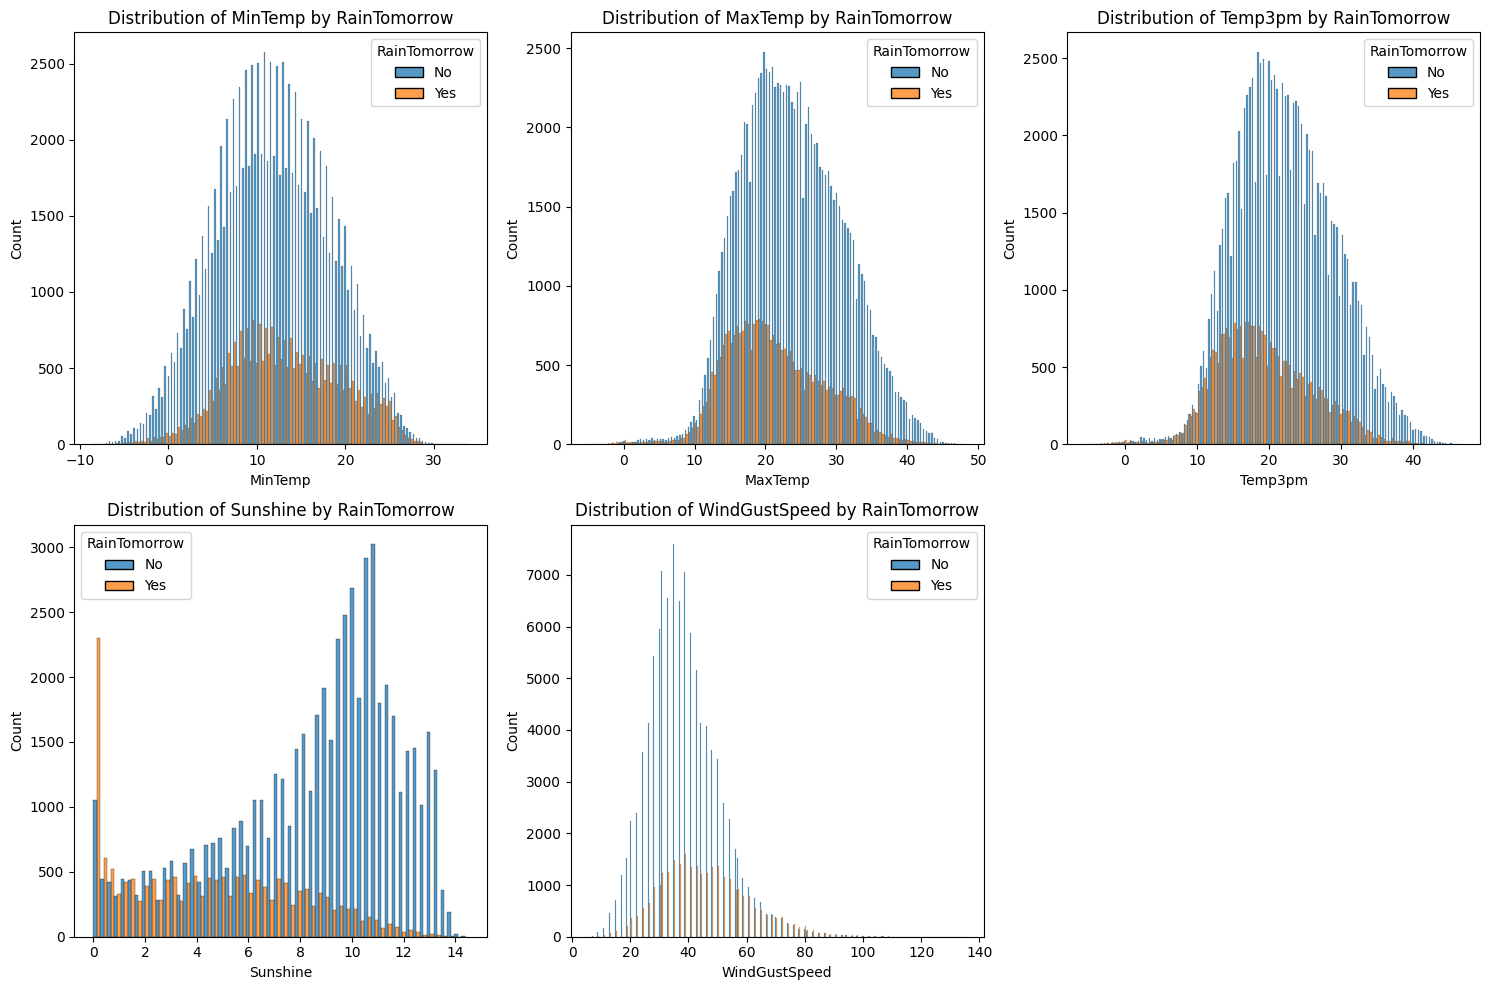

In [8]:
# Visualize feature distributions
cols = ['MinTemp', 'MaxTemp', 'Temp3pm', 'Sunshine', 'WindGustSpeed']  # Removed WindGustDir as it's categorical
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    if col in df.columns:
        sns.histplot(data=df, x=col, hue='RainTomorrow', multiple='dodge', ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by RainTomorrow')

# Hide any unused subplots
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


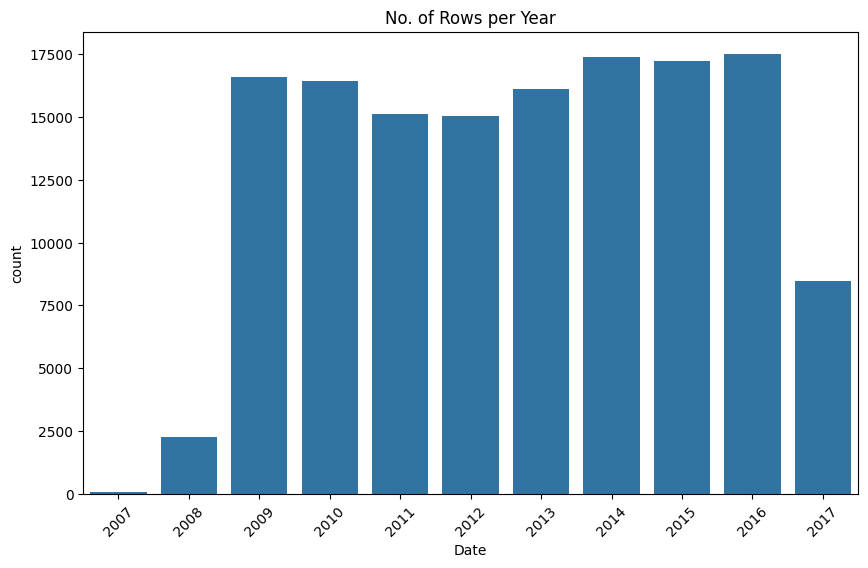

In [9]:
# Visualize data distribution by year
plt.figure(figsize=(10, 6))
plt.title('No. of Rows per Year')
years = pd.to_datetime(df['Date']).dt.year
sns.countplot(data=df, x=years)
plt.xticks(rotation=45)
plt.show()

In [10]:
# Split data by year
year = pd.to_datetime(df['Date']).dt.year
x_train = df[year < 2015].copy()
x_val = df[year == 2015].copy()
x_test = df[year > 2015].copy()

In [11]:
print(f"\nData splits:")
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")


Data splits:
Training set shape: (98988, 23)
Validation set shape: (17231, 23)
Test set shape: (25974, 23)


In [12]:
# Define feature and target columns
x_col = list(df.columns)[1:-1]  # All columns except Date and RainTomorrow
y_col = 'RainTomorrow'
print(f"\nFeature columns ({len(x_col)}): {x_col}")
print(f"Target column: {y_col}")


Feature columns (21): ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
Target column: RainTomorrow


In [13]:
# Create feature and target sets
x_train_input = x_train[x_col].copy()
y_train_target = x_train[y_col].copy()  # Fixed variable name
x_val_input = x_val[x_col].copy()
y_val_target = x_val[y_col].copy()    # Fixed variable name
x_test_input = x_test[x_col].copy()
y_test_target = x_test[y_col].copy()  # Fixed variable name

In [14]:
print("\nTraining features sample:")
print(x_train_input.head())


Training features sample:
  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0   Albury     13.4     22.9       0.6          NaN       NaN           W   
1   Albury      7.4     25.1       0.0          NaN       NaN         WNW   
2   Albury     12.9     25.7       0.0          NaN       NaN         WSW   
3   Albury      9.2     28.0       0.0          NaN       NaN          NE   
4   Albury     17.5     32.3       1.0          NaN       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  ...  WindSpeed3pm  Humidity9am  \
0           44.0          W        WNW  ...          24.0         71.0   
1           44.0        NNW        WSW  ...          22.0         44.0   
2           46.0          W        WSW  ...          26.0         38.0   
3           24.0         SE          E  ...           9.0         45.0   
4           41.0        ENE         NW  ...          20.0         82.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Tem

In [15]:
print("\nTraining targets sample:")
print(y_train_target.head())  # Fixed variable name


Training targets sample:
0    No
1    No
2    No
3    No
4    No
Name: RainTomorrow, dtype: object


In [16]:
# Identify numerical and categorical columns
numerical_cols = x_train_input.select_dtypes(include=np.number).columns.tolist()
categorical_cols = x_train_input.select_dtypes(include=['object']).columns.tolist()
print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")


Numerical columns (16): ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical columns (5): ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [17]:
print("\nNumerical features statistics:")
print(x_train_input[numerical_cols].describe())


Numerical features statistics:
            MinTemp      MaxTemp      Rainfall  Evaporation      Sunshine  \
count  98554.000000  98790.00000  97988.000000  61878.00000  58292.000000   
mean      12.002014     23.00288      2.372935      5.28686      7.602136   
std        6.345487      6.99008      8.518819      3.95104      3.788266   
min       -8.500000     -4.10000      0.000000      0.00000      0.000000   
25%        7.500000     17.80000      0.000000      2.60000      4.800000   
50%       11.800000     22.40000      0.000000      4.60000      8.400000   
75%       16.600000     27.90000      0.800000      7.20000     10.600000   
max       33.900000     48.10000    371.000000     82.40000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   92086.000000  97855.000000  97848.000000  97723.000000  97802.000000   
mean       40.230969     14.102192     18.770430     68.651822     51.501728   
std        13.713042      8.994121

<ipython-input-18-8f3c5cc82fa6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


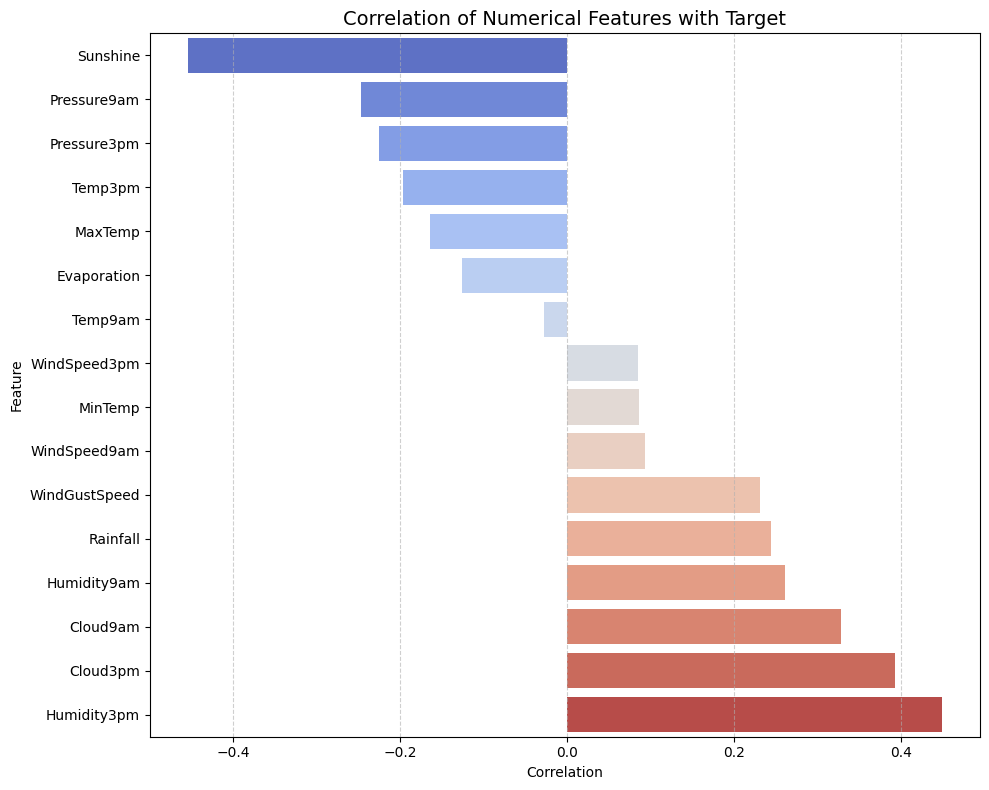

In [18]:
# Correlation analysis
if numerical_cols:  # Only if there are numerical columns
    corr_data = x_train_input[numerical_cols].copy()
    corr_data['Target'] = y_train_target.map({'Yes': 1, 'No': 0})

    target_corr = corr_data.corr()['Target'].drop('Target').sort_values()

    plt.figure(figsize=(10, 8))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
    plt.title('Correlation of Numerical Features with Target', fontsize=14)
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [65]:
print("\n" + "="*60)
print("STEP N: RANDOMFOREST CLASSIFIER")
print("="*60)


STEP N: RANDOMFOREST CLASSIFIER


In [19]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [20]:
print("\nFitting the model...")
model_pipeline.fit(x_train_input, y_train_target)


Fitting the model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainToday'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [21]:
# Make predictions on validation set
print("\nEvaluating on validation set...")
y_val_pred = model_pipeline.predict(x_val_input)
val_accuracy = accuracy_score(y_val_target, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Evaluating on validation set...
Validation Accuracy: 0.8556


In [22]:
print("\nValidation Classification Report:")
print(classification_report(y_val_target, y_val_pred))


Validation Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.97      0.91     13583
         Yes       0.78      0.44      0.56      3648

    accuracy                           0.86     17231
   macro avg       0.82      0.70      0.74     17231
weighted avg       0.85      0.86      0.84     17231



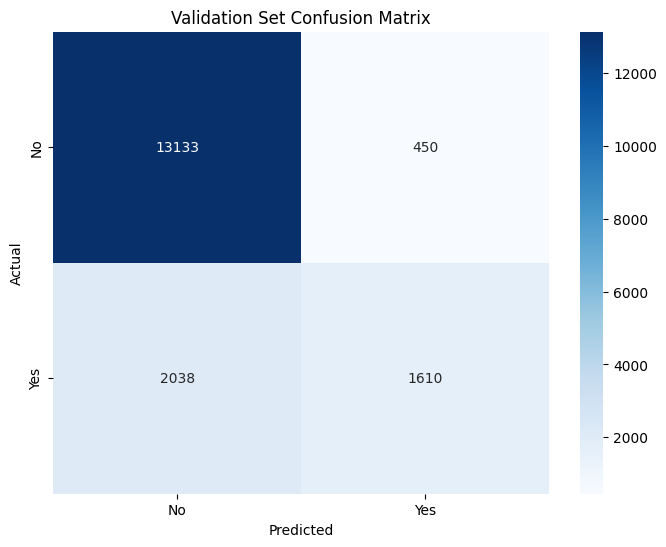

In [23]:
# Confusion matrix for validation set
plt.figure(figsize=(8, 6))
cm_val = confusion_matrix(y_val_target, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
print("\nEvaluating on test set...")
y_test_pred = model_pipeline.predict(x_test_input)
test_accuracy = accuracy_score(y_test_target, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating on test set...
Test Accuracy: 0.8430


In [25]:
print("\nTest Classification Report:")
print(classification_report(y_test_target, y_test_pred))


Test Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90     20028
         Yes       0.75      0.47      0.58      5946

    accuracy                           0.84     25974
   macro avg       0.81      0.71      0.74     25974
weighted avg       0.83      0.84      0.83     25974



Text(70.72222222222221, 0.5, 'Actual')

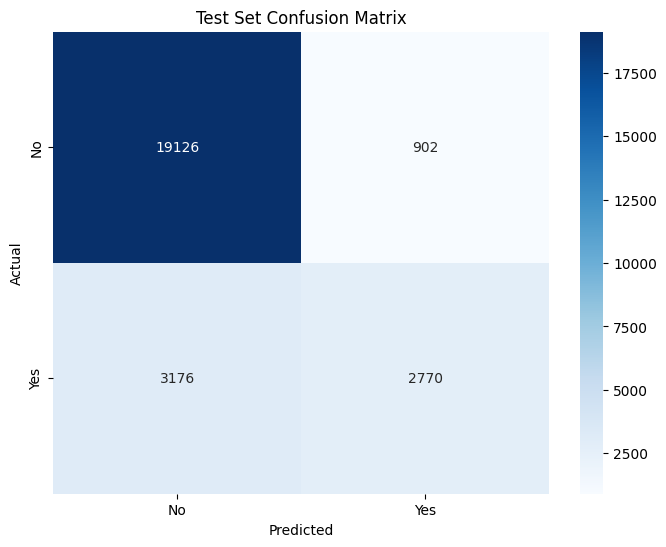

In [26]:
# Confusion matrix for the test set
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test_target, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

<ipython-input-27-876f67eed1ce>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


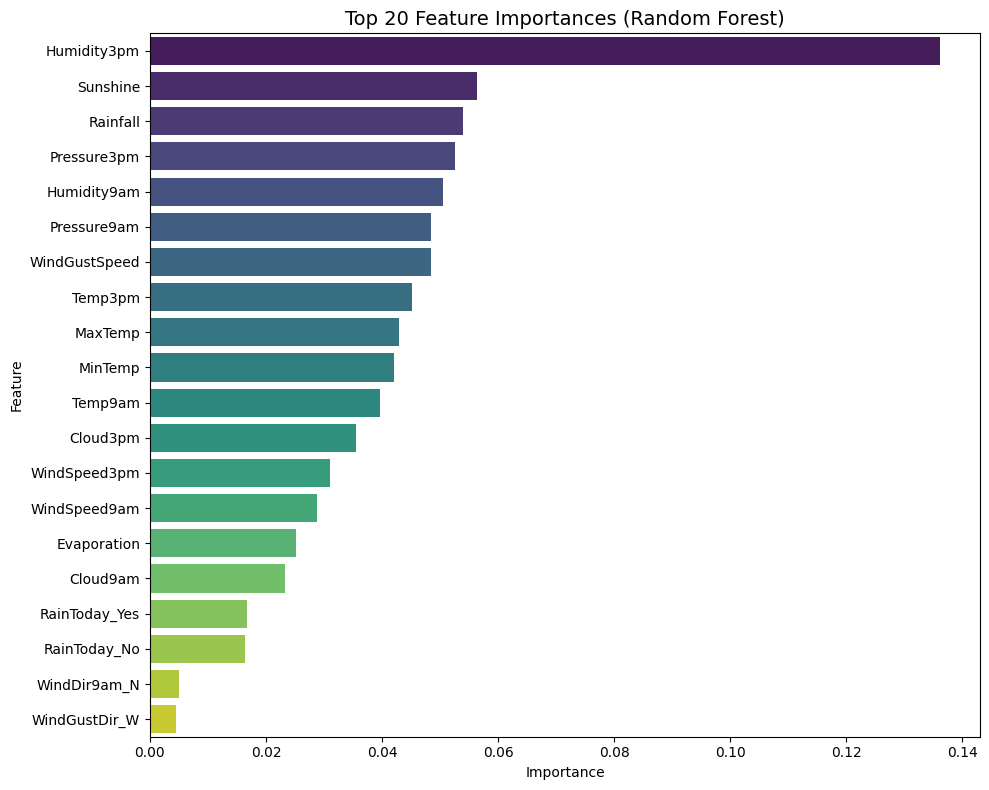


Top 10 Most Important Features:
          feature  importance
9     Humidity3pm    0.136232
4        Sunshine    0.056421
2        Rainfall    0.053907
11    Pressure3pm    0.052574
8     Humidity9am    0.050524
10    Pressure9am    0.048444
5   WindGustSpeed    0.048382
15        Temp3pm    0.045087
1         MaxTemp    0.042919
0         MinTemp    0.041981

=== Model Training Complete ===
Final Validation Accuracy: 0.8556
Final Test Accuracy: 0.8430


In [27]:
# Feature importance analysis
if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = []

    # Add numerical feature names
    feature_names.extend(numerical_cols)

    # Add categorical feature names (after one-hot encoding)
    if categorical_cols:
        cat_encoder = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
        feature_names.extend(cat_feature_names)

    # Get feature importances
    importances = model_pipeline.named_steps['classifier'].feature_importances_

    # Create DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(20)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('Top 20 Feature Importances (Random Forest)', fontsize=14)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

print("\n=== Model Training Complete ===")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

In [67]:
print("\n" + "="*50)
print("RANDOMFOREST HYPERPARAMETR TUNING")
print("="*50)


RANDOMFOREST HYPERPARAMETR TUNING


In [70]:
def rf_tuning(x_train, y_train, x_val, y_val):
    results = []
    for n_estimators in [50, 100, 200, 300]:
      pipeline = Pipeline(
          steps=[
              ('preprocessor', preprocessor),
              ('classifier', RandomForestClassifier(
                  n_estimators=n_estimators,
                  random_state=42,
                  ))
          ])
      pipeline.fit(x_train, y_train)
      y_val_pred = pipeline.predict(x_val)
      accuracy = accuracy_score(y_val, y_val_pred)
      results.append({
          'n_estimators': n_estimators,
          'validation_accuracy': accuracy
        })

      print(f"n_estimators {n_estimators:2d}: Validation Accuracy = {accuracy:.4f}")
      best_result = max(results, key=lambda x: x['validation_accuracy'])
      print(f"Best n_estimators: {best_result['n_estimators']}")

    return results

In [72]:
# rf_tuning(x_train_input, y_train_target, x_val_input, y_val_target)

In [29]:
print("\n" + "="*50)
print("TRAINING DECISION TREE CLASSIFIER")
print("="*50)


TRAINING DECISION TREE CLASSIFIER


In [31]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        max_depth=10,           # Limit depth to prevent overfitting
        min_samples_split=20,   # Minimum samples to split
        min_samples_leaf=10,    # Minimum samples in leaf
        ))
])

In [33]:
print("\nFitting Decision Tree model...")
dt_pipeline.fit(x_train_input, y_train_target)


Fitting Decision Tree model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainToday'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=10,
                                        min_samples_split=20,
                                        random_state=42))])

In [35]:
# Decision Tree - Validation Set Evaluation
print("\nDecision Tree - Evaluating on validation set...")
y_val_pred_dt = dt_pipeline.predict(x_val_input)
val_accuracy_dt = accuracy_score(y_val_target, y_val_pred_dt)
print(f"Decision Tree Validation Accuracy: {val_accuracy_dt:.4f}")


Decision Tree - Evaluating on validation set...
Decision Tree Validation Accuracy: 0.8416


In [36]:
print("\nDecision Tree Validation Classification Report:")
print(classification_report(y_val_target, y_val_pred_dt))


Decision Tree Validation Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90     13583
         Yes       0.70      0.44      0.54      3648

    accuracy                           0.84     17231
   macro avg       0.78      0.70      0.72     17231
weighted avg       0.83      0.84      0.83     17231



In [37]:
# Decision Tree - Test Set Evaluation\
print("\nDecision Tree - Evaluating on test set...")
y_test_pred_dt = dt_pipeline.predict(x_test_input)
test_accuracy_dt = accuracy_score(y_test_target, y_test_pred_dt)
print(f"Decision Tree Test Accuracy: {test_accuracy_dt:.4f}")


Decision Tree - Evaluating on test set...
Decision Tree Test Accuracy: 0.8305


In [38]:
print("\nDecision Tree Test Classification Report:")
print(classification_report(y_test_target, y_test_pred_dt))


Decision Tree Test Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.94      0.90     20028
         Yes       0.71      0.45      0.55      5946

    accuracy                           0.83     25974
   macro avg       0.78      0.70      0.72     25974
weighted avg       0.82      0.83      0.82     25974



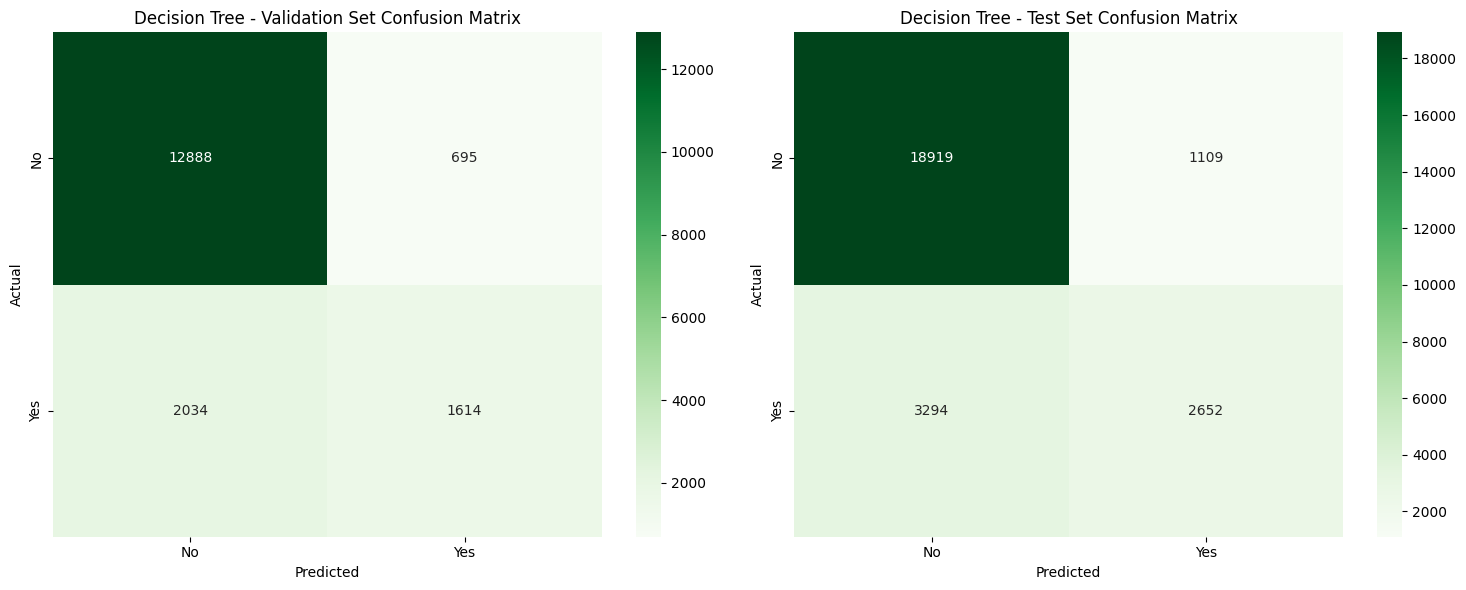

In [41]:
# Decision Tree Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Validation confusion matrix
cm_val_dt = confusion_matrix(y_val_target, y_val_pred_dt)
sns.heatmap(cm_val_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=ax1)
ax1.set_title('Decision Tree - Validation Set Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Test confusion matrix
cm_test_dt = confusion_matrix(y_test_target, y_test_pred_dt)
sns.heatmap(cm_test_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=ax2)
ax2.set_title('Decision Tree - Test Set Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

<ipython-input-42-45d52ff50508>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features_dt, x='importance', y='feature', palette='plasma')


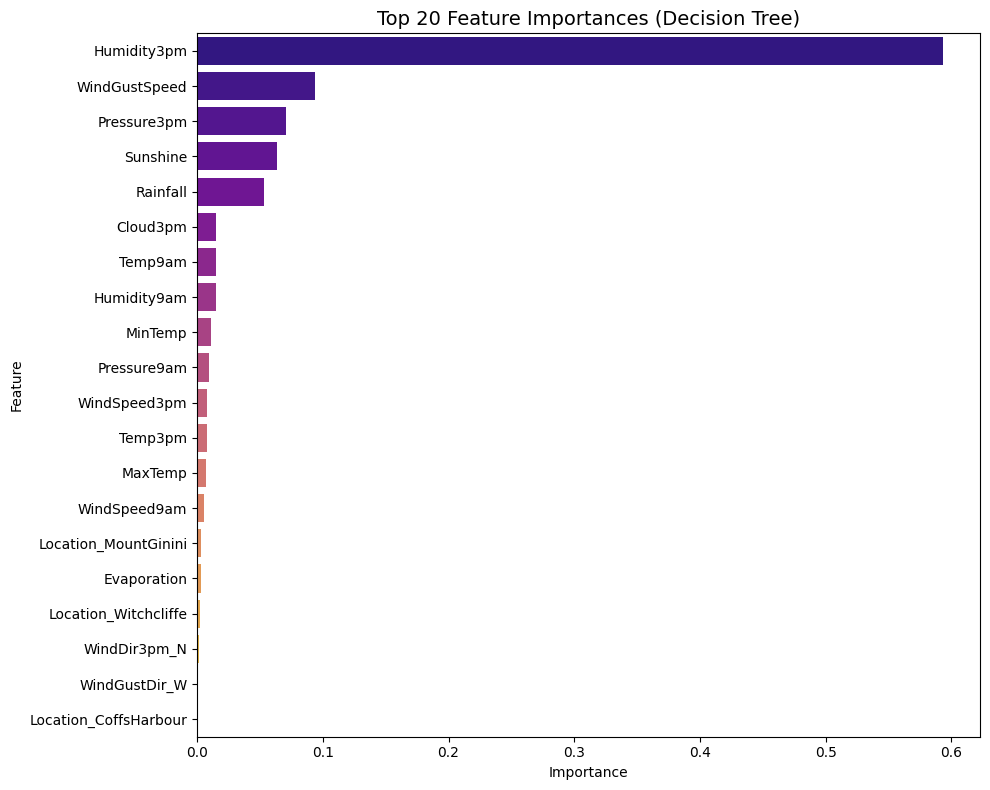


Decision Tree - Top 10 Most Important Features:
          feature  importance
9     Humidity3pm    0.593211
5   WindGustSpeed    0.093914
11    Pressure3pm    0.070702
4        Sunshine    0.063142
2        Rainfall    0.053149
13       Cloud3pm    0.015390
14        Temp9am    0.015245
8     Humidity9am    0.015094
0         MinTemp    0.010678
10    Pressure9am    0.009495


In [42]:
# Decision Tree Feature Importance
if hasattr(dt_pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names (same as Random Forest)
    feature_names = []
    feature_names.extend(numerical_cols)

    if categorical_cols:
        cat_encoder = dt_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
        feature_names.extend(cat_feature_names)

    # Get Decision Tree feature importances
    importances_dt = dt_pipeline.named_steps['classifier'].feature_importances_

    # Create DataFrame
    feature_importance_dt_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances_dt
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_features_dt = feature_importance_dt_df.head(20)
    sns.barplot(data=top_features_dt, x='importance', y='feature', palette='plasma')
    plt.title('Top 20 Feature Importances (Decision Tree)', fontsize=14)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    print("\nDecision Tree - Top 10 Most Important Features:")
    print(feature_importance_dt_df.head(10))


DECISION TREE VISUALIZATION


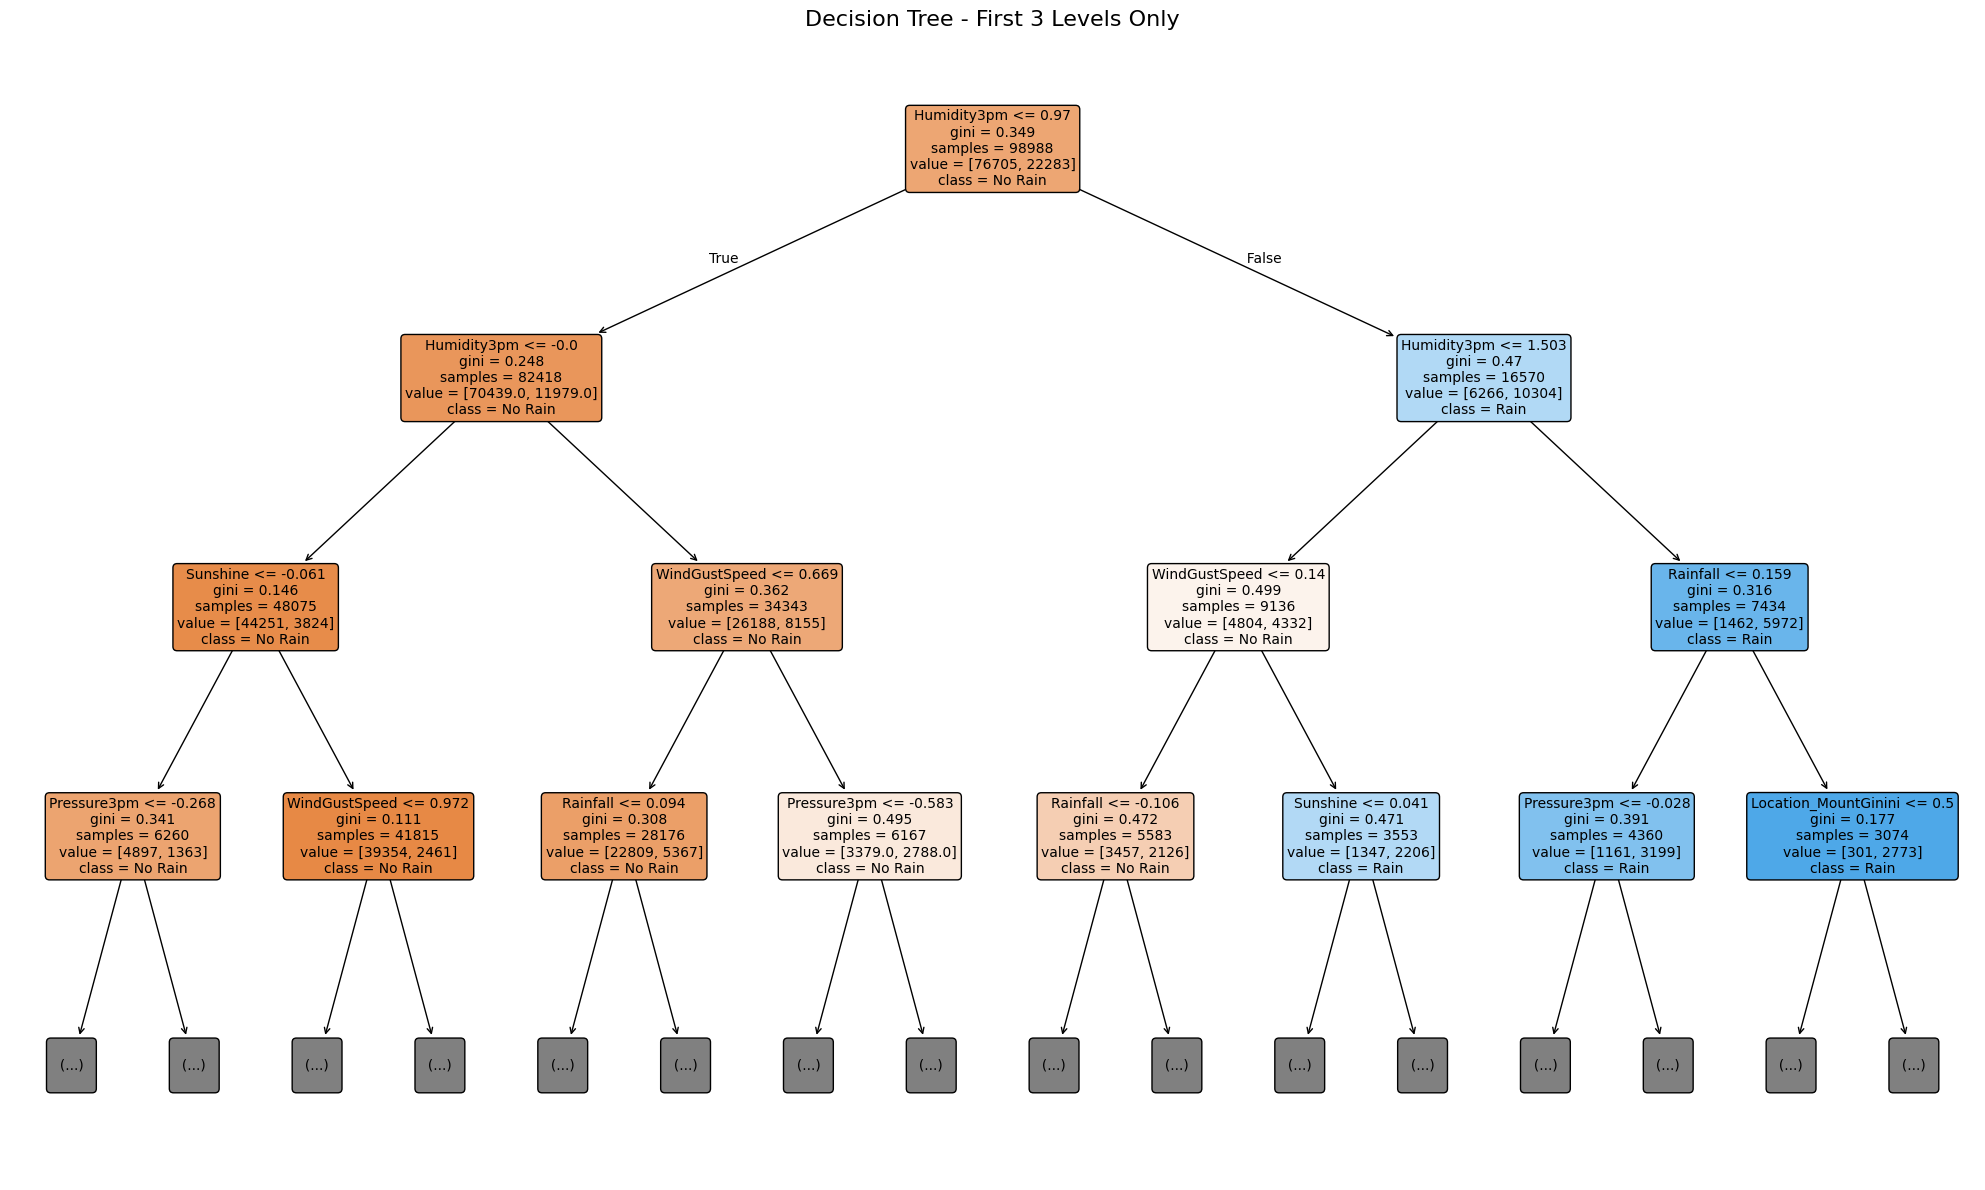

In [48]:
# =============================================================================
# DECISION TREE VISUALIZATION
# =============================================================================

print("\n" + "="*50)
print("DECISION TREE VISUALIZATION")
print("="*50)

from sklearn.tree import plot_tree, export_text

# Get the trained decision tree classifier
dt_classifier = dt_pipeline.named_steps['classifier']

# Get feature names after preprocessing (same as before)
feature_names = []
feature_names.extend(numerical_cols)

if categorical_cols:
    cat_encoder = dt_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_feature_names)

# Method 2: Simplified Tree (first few levels only)
plt.figure(figsize=(20, 12))
plot_tree(dt_classifier,
          feature_names=feature_names,
          class_names=['No Rain', 'Rain'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Show only first 3 levels
plt.title('Decision Tree - First 3 Levels Only', fontsize=16)
plt.tight_layout()
plt.show()

In [52]:
# Method 1: Access the classifier from the pipeline
dt_classifier = dt_pipeline.named_steps['classifier']
print(f"Max Depth: {dt_classifier.get_depth()}")
print(f"Number of Leaves: {dt_classifier.get_n_leaves()}")

Max Depth: 10
Number of Leaves: 656


In [54]:
print("\n" + "="*60)
print("STEP 3: HYPERPARAMETER TUNING METHODS")
print("="*60)


STEP 3: HYPERPARAMETER TUNING METHODS


In [58]:
def dt_tuning(x_train, y_train, x_val, y_val):
    results = []
    for depth in range(1, 21):
      pipeline = Pipeline(
          steps=[
              ('preprocessor', preprocessor),
              ('classifier', DecisionTreeClassifier(
                  random_state=42,
                  max_depth=depth,
                  min_samples_split=20,
                  min_samples_leaf=10,
                  ))
          ]
      )
      pipeline.fit(x_train, y_train)
      y_val_pred = pipeline.predict(x_val)
      accuracy = accuracy_score(y_val, y_val_pred)
      results.append({
          'max_depth': depth,
          'validation_accuracy': accuracy
        })

    print(f"Max Depth {depth:2d}: Validation Accuracy = {accuracy:.4f}")
    best_result = max(results, key=lambda x: x['validation_accuracy'])
    print(f"Best Max Depth: {best_result['max_depth']}")

    return results

In [59]:
dt_tuning(x_train_input, y_train_target, x_val_input, y_val_target)

Max Depth 20: Validation Accuracy = 0.8262
Best Max Depth: 9


[{'max_depth': 1, 'validation_accuracy': 0.8220648830596019},
 {'max_depth': 2, 'validation_accuracy': 0.8272880273924903},
 {'max_depth': 3, 'validation_accuracy': 0.8334397307178921},
 {'max_depth': 4, 'validation_accuracy': 0.8368057570657536},
 {'max_depth': 5, 'validation_accuracy': 0.8402878532876792},
 {'max_depth': 6, 'validation_accuracy': 0.8412744472172248},
 {'max_depth': 7, 'validation_accuracy': 0.8429574603911555},
 {'max_depth': 8, 'validation_accuracy': 0.8424931808948988},
 {'max_depth': 9, 'validation_accuracy': 0.844582438628054},
 {'max_depth': 10, 'validation_accuracy': 0.8416226568394173},
 {'max_depth': 11, 'validation_accuracy': 0.8415646219023852},
 {'max_depth': 12, 'validation_accuracy': 0.8394173292321978},
 {'max_depth': 13, 'validation_accuracy': 0.8347745342696303},
 {'max_depth': 14, 'validation_accuracy': 0.8331495560327317},
 {'max_depth': 15, 'validation_accuracy': 0.8322209970402182},
 {'max_depth': 16, 'validation_accuracy': 0.8310602982995764},
 {

In [63]:
from sklearn.model_selection import GridSearchCV

def grid_search_example(x_train, y_train, preprocessor):
    """
    Use GridSearchCV for systematic hyperparameter tuning
    """
    print("\n🔍 Grid Search: Testing all combinations...")

    # Create base pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    # Define parameter grid (start small!)
    param_grid = {
        'classifier__max_depth': [3, 5, 7, 9],
        'classifier__min_samples_split': [10, 20, 50],
        'classifier__min_samples_leaf': [5, 10, 20]
    }

    print("Parameters to test:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")

    total_combinations = 1
    for values in param_grid.values():
        total_combinations *= len(values)
    print(f"Total combinations: {total_combinations}")

    # Perform grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,  # 3-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )

    print("\n⏳ Training... (this might take a few minutes)")
    grid_search.fit(x_train, y_train)

    print("\n🏆 BEST PARAMETERS FOUND:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

    return grid_search

In [64]:
grid_search_example(x_train_input, y_train_target, preprocessor)


🔍 Grid Search: Testing all combinations...
Parameters to test:
  classifier__max_depth: [3, 5, 7, 9]
  classifier__min_samples_split: [10, 20, 50]
  classifier__min_samples_leaf: [5, 10, 20]
Total combinations: 36

⏳ Training... (this might take a few minutes)
Fitting 3 folds for each of 36 candidates, totalling 108 fits

🏆 BEST PARAMETERS FOUND:
  classifier__max_depth: 7
  classifier__min_samples_leaf: 20
  classifier__min_samples_split: 10

Best Cross-Validation Score: 0.8288


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          '...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainToday'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, 7, 9],
                         'classifier__min_samples_leaf': [5, 10, 20],
                         'classifier__min_samples_split': [10, 20, 50]},
             scoring='accuracy', verbose=1)